In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sn
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
%matplotlib inline

In [2]:
#helper function
def item(df, category, sample_size = 1, healthy=False):
    t_df = df.query('Category == "{}"'.format(category))
    if healthy:
        t_df = t_df.sort_values('Calories').head()
    return t_df.sample(sample_size)

In [3]:
#helper function
def get_df(df, num_samples, lo_cal):
    items = []
    nutrition = []
    col_names = None
    for i in range(num_samples):
        bf = item(df, 'Breakfast', 1, lo_cal)#breakfast item
        bf_drink = item(df, "Coffee & Tea", 1, lo_cal)#breakfast drink
        snacks = item(df, "Snacks & Sides", 4, lo_cal) #2 daily snacks plus 2 meal sides
        lunch = item(df, "Chicken & Fish", 1, lo_cal) #lunch/dinner sandwich 
        bevs = item(df, "Beverages", 2, lo_cal) #lunch and dinner drink
        dinner = item(df, "Beef & Pork", 1, lo_cal) #lunch/dinner sandwich
        dessert = item(df, "Desserts", 1, lo_cal) #of course
        frames = [bf, bf_drink, snacks, lunch, dinner, bevs, dessert]
        t_df = pd.concat(frames)
        items.append(t_df.Item)
        if i == 0:
            col_names = t_df.sum(numeric_only = True).index
        nutrition.append(t_df.sum(numeric_only = True).values)
    return pd.DataFrame(nutrition, columns = col_names), items

https://globalnews.ca/news/3615212/this-is-what-your-breakfast-lunch-and-dinner-calories-actually-look-like/ Although every person’s daily caloric intake is individual, based on their personal goals and needs, nutrition experts estimate that average daily consumption at each meal should be broken down as follows: 300 to 400 calories for breakfast, and 500 to 700 calories each for lunch and dinner. Snacks shouldn’t exceed 200 calories.

null hypothesis: we cannot have a healthy day of meals at mcdonalds

hypothesis : we can have a healthy day of meals at mcdonalds

healthy is defined as between 1700 and 2200 calories, daily values not exceeded where appropriate and met where appropriate.

In [39]:
df = pd.read_csv('menu.csv')
df.sample(5)

,Category,Item,Serving Size,Calories,Calories from Fat,Total Fat,Total Fat (% Daily Value),Saturated Fat,Saturated Fat (% Daily Value),Trans Fat,...,Carbohydrates,Carbohydrates (% Daily Value),Dietary Fiber,Dietary Fiber (% Daily Value),Sugars,Protein,Vitamin A (% Daily Value),Vitamin C (% Daily Value),Calcium (% Daily Value),Iron (% Daily Value)
20,Breakfast,"Bacon, Egg & Cheese McGriddles with Egg Whites",6.3 oz (178 g),400,140,15.0,24,7.0,34,0.0,...,47,16,2,9,16,20,2,10,15,10
196,Coffee & Tea,Regular Iced Coffee (Small),16 fl oz cup,140,40,4.5,7,3.0,15,0.0,...,23,8,0,0,22,1,4,0,4,0
103,Desserts,Baked Apple Pie,2.7 oz (77 g),250,110,13.0,19,7.0,35,0.0,...,32,11,4,15,13,2,4,25,2,6
38,Breakfast,Hash Brown,2 oz (56 g),150,80,9.0,14,1.5,6,0.0,...,15,5,2,6,0,1,0,2,0,2
26,Breakfast,"Steak, Egg & Cheese Bagel",8.5 oz (241 g),670,310,35.0,53,13.0,63,1.5,...,56,19,3,12,7,33,20,4,25,25


In [40]:
#no known missing data, mostly numeric
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260 entries, 0 to 259
Data columns (total 24 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Category                       260 non-null    object 
 1   Item                           260 non-null    object 
 2   Serving Size                   260 non-null    object 
 3   Calories                       260 non-null    int64  
 4   Calories from Fat              260 non-null    int64  
 5   Total Fat                      260 non-null    float64
 6   Total Fat (% Daily Value)      260 non-null    int64  
 7   Saturated Fat                  260 non-null    float64
 8   Saturated Fat (% Daily Value)  260 non-null    int64  
 9   Trans Fat                      260 non-null    float64
 10  Cholesterol                    260 non-null    int64  
 11  Cholesterol (% Daily Value)    260 non-null    int64  
 12  Sodium                         260 non-null    int

In [41]:
df.describe()

,Calories,Calories from Fat,Total Fat,Total Fat (% Daily Value),Saturated Fat,Saturated Fat (% Daily Value),Trans Fat,Cholesterol,Cholesterol (% Daily Value),Sodium,...,Carbohydrates,Carbohydrates (% Daily Value),Dietary Fiber,Dietary Fiber (% Daily Value),Sugars,Protein,Vitamin A (% Daily Value),Vitamin C (% Daily Value),Calcium (% Daily Value),Iron (% Daily Value)
count,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,...,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000
mean,368.269231,127.096154,14.165385,21.815385,6.007692,29.965385,0.203846,54.942308,18.392308,495.750000,...,47.346154,15.780769,1.630769,6.530769,29.423077,13.338462,13.426923,8.534615,20.973077,7.734615
std,240.269886,127.875914,14.205998,21.885199,5.321873,26.639209,0.429133,87.269257,29.091653,577.026323,...,28.252232,9.419544,1.567717,6.307057,28.679797,11.426146,24.366381,26.345542,17.019953,8.723263
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,210.000000,20.000000,2.375000,3.750000,1.000000,4.750000,0.000000,5.000000,2.000000,107.500000,...,30.000000,10.000000,0.000000,0.000000,5.750000,4.000000,2.000000,0.000000,6.000000,0.000000
50%,340.000000,100.000000,11.000000,17.000000,5.000000,24.000000,0.000000,35.000000,11.000000,190.000000,...,44.000000,15.000000,1.000000,5.000000,17.500000,12.000000,8.000000,0.000000,20.000000,4.000000
75%,500.000000,200.000000,22.250000,35.000000,10.000000,48.000000,0.000000,65.000000,21.250000,865.000000,...,60.000000,20.000000,3.000000,10.000000,48.000000,19.000000,15.000000,4.000000,30.000000,15.000000
max,1880.000000,1060.000000,118.000000,182.000000,20.000000,102.000000,2.500000,575.000000,192.000000,3600.000000,...,141.000000,47.000000,7.000000,28.000000,128.000000,87.000000,170.000000,240.000000,70.000000,40.000000


In [42]:
df.columns

Index(['Category', 'Item', 'Serving Size', 'Calories', 'Calories from Fat',
       'Total Fat', 'Total Fat (% Daily Value)', 'Saturated Fat',
       'Saturated Fat (% Daily Value)', 'Trans Fat', 'Cholesterol',
       'Cholesterol (% Daily Value)', 'Sodium', 'Sodium (% Daily Value)',
       'Carbohydrates', 'Carbohydrates (% Daily Value)', 'Dietary Fiber',
       'Dietary Fiber (% Daily Value)', 'Sugars', 'Protein',
       'Vitamin A (% Daily Value)', 'Vitamin C (% Daily Value)',
       'Calcium (% Daily Value)', 'Iron (% Daily Value)'],
      dtype='object')

In [43]:
df.Category.unique()

array(['Breakfast', 'Beef & Pork', 'Chicken & Fish', 'Salads',
       'Snacks & Sides', 'Desserts', 'Beverages', 'Coffee & Tea',
       'Smoothies & Shakes'], dtype=object)

In [9]:
#random day of meals, healthy day of meals uses random choice of top five lowest calories
random_df, random_items = get_df(df, 1000, False)
healthy_df, healthy_items = get_df(df, 1000, True)

In [10]:
#combine random and healthy df with flag
healthy_df['healthy'] = 'healthy'
frames = [random_df, healthy_df]
combined_df = pd.concat(frames)
combined_df.fillna('random', inplace = True)
combined_df.tail()

,Calories,Calories from Fat,Total Fat,Total Fat (% Daily Value),Saturated Fat,Saturated Fat (% Daily Value),Trans Fat,Cholesterol,Cholesterol (% Daily Value),Sodium,...,Carbohydrates (% Daily Value),Dietary Fiber,Dietary Fiber (% Daily Value),Sugars,Protein,Vitamin A (% Daily Value),Vitamin C (% Daily Value),Calcium (% Daily Value),Iron (% Daily Value),healthy
995,1525.0,455.0,50.0,77.0,18.0,89.0,1.0,165.0,56.0,2135.0,...,68.0,14.0,57.0,90.0,67.0,63.0,361.0,61.0,68.0,healthy
996,1730.0,560.0,60.0,94.0,21.5,106.0,0.5,255.0,85.0,2860.0,...,76.0,11.0,49.0,87.0,75.0,75.0,101.0,82.0,64.0,healthy
997,1465.0,600.0,66.0,102.0,19.0,93.0,1.0,140.0,46.0,2160.0,...,55.0,9.0,38.0,57.0,51.0,59.0,240.0,46.0,36.0,healthy
998,1130.0,440.0,48.5,74.0,11.0,52.0,0.0,65.0,23.0,1655.0,...,48.0,8.0,32.0,38.0,36.0,6.0,226.0,26.0,29.0,healthy
999,1245.0,440.0,48.0,74.0,13.5,65.0,0.0,100.0,33.0,1810.0,...,55.0,7.0,30.0,79.0,45.0,57.0,225.0,46.0,31.0,healthy


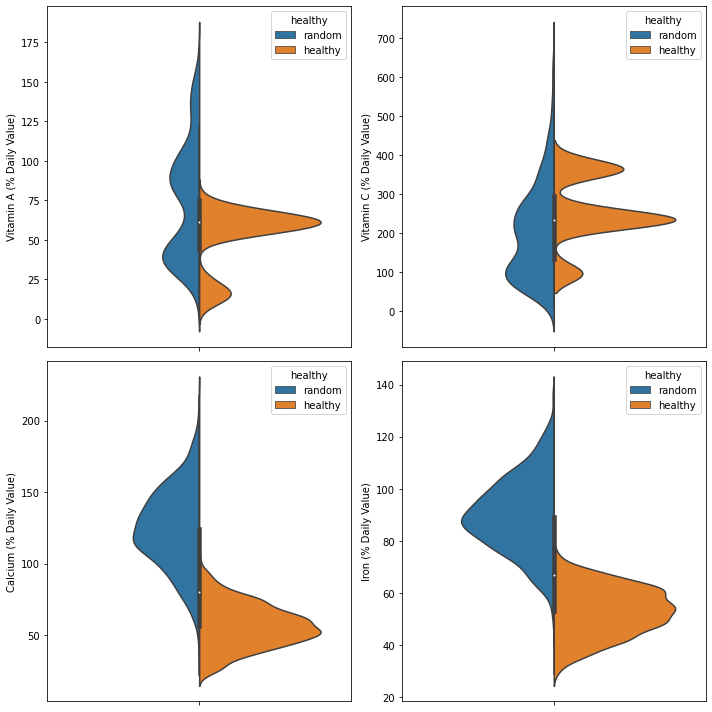

In [11]:
#plot vitamin and mineral columns
combined_df["all"] = "" #added for plotting purpose
vitmin_cols  = ['Vitamin A (% Daily Value)', 'Vitamin C (% Daily Value)',\
                'Calcium (% Daily Value)', 'Iron (% Daily Value)']
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
i = 0
for row in axes:
    for ax in row:
        sn.violinplot(x = 'all', y = vitmin_cols[i], hue = 'healthy', data = combined_df, split = True, ax = ax).set_xlabel('')
        
        i += 1
plt.tight_layout()
plt.show()

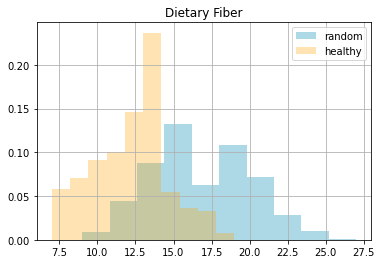

In [12]:
#Women should try to eat at least 21 to 25 grams of fiber a day, while men should aim for 30 to 38 grams a day.
#https://www.mayoclinic.org/healthy-lifestyle/nutrition-and-healthy-eating/in-depth/high-fiber-foods/art-20050948
###It already looks difficult to have a healthy day of meals, but...
plt.title('Dietary Fiber')
random_df['Dietary Fiber'].hist(color = 'lightblue', label = 'random', density = True);
healthy_df['Dietary Fiber'].hist(color = 'orange', alpha = 0.3, label = 'healthy', density = True)
plt.legend();

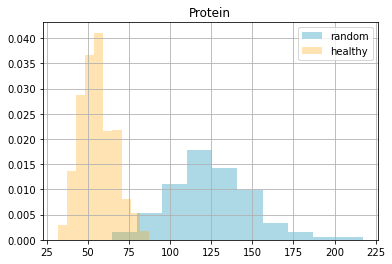

In [13]:
#Adult men need about 56 grams a day. Adult women need about 46 grams a day
#https://www.webmd.com/food-recipes/protein
#Protein looks attainable, but too much? ask SME
plt.title('Protein')
random_df['Protein'].hist(color = 'lightblue', label = 'random', density = True);
healthy_df['Protein'].hist(color = 'orange', alpha = 0.3, label = 'healthy', density = True)
plt.legend();

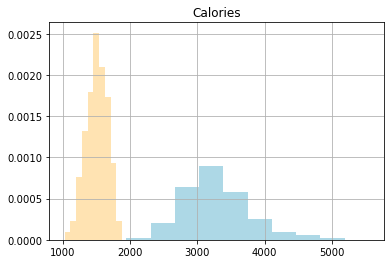

In [14]:
#1700-2200 recommended
#HMMMMMMMMMM..
plt.title('Calories')
combined_df.query('healthy == "healthy"').Calories.hist(color = 'orange', alpha = .3, density = True);
combined_df.query('healthy == "random"').Calories.hist(color = 'lightblue', density = True);

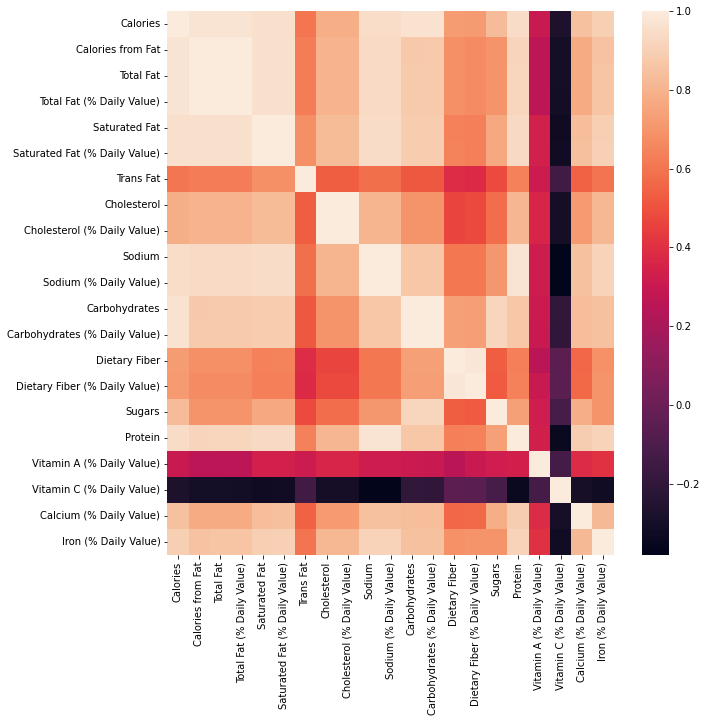

In [15]:
#a lot of multicolinearity. somewhat expected, as more calories consumed all values go up. Vitamin C????
plt.figure(figsize = (10,10))
sn.heatmap(combined_df.drop('all', axis = 1).corr());

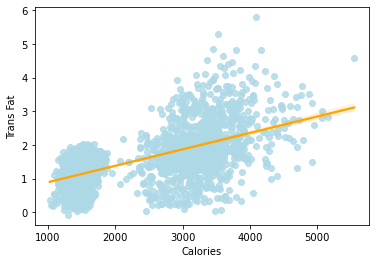

In [16]:
#plot calories and trans fat. discrete numeric needs jitter, but probably not good for prediction
jitter = np.random.normal(loc = .5, scale = 0.2, size = len(combined_df))
trans_fat_jitter = combined_df['Trans Fat'] + jitter
fig, ax = plt.subplots()
ax = sn.regplot(x = 'Calories', y = trans_fat_jitter, data = combined_df, scatter_kws={'color': 'lightblue'}, line_kws={'color': 'orange'})
plt.show()

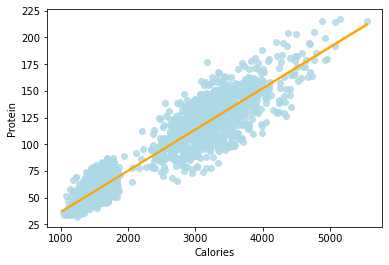

In [17]:
#protein better for predicting
fig, ax = plt.subplots()
ax = sn.regplot(x = 'Calories', y = 'Protein', data = combined_df, scatter_kws={'color': 'lightblue'}, line_kws={'color': 'orange'})
plt.show()

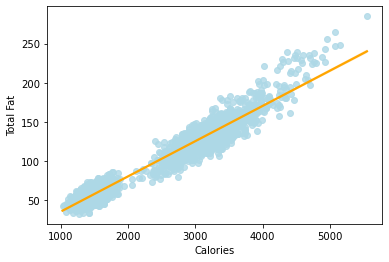

In [18]:
#total fat looks really good for predictions
fig, ax = plt.subplots()
ax = sn.regplot(x = 'Calories', y = 'Total Fat', data = combined_df, scatter_kws={'color': 'lightblue'}, line_kws={'color': 'orange'})
plt.show()

In [19]:
#build and train simple regression model for protein/calories
#pretty good as expected
x = combined_df['Calories']
y = combined_df['Protein']#'Saturated Fat (% Daily Value)']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = .2)
x_train = np.array(x_train).reshape(-1, 1)
x_test = np.array(x_test).reshape(-1, 1)
lr_model = LinearRegression()
lr_model.fit(x_train, y_train)
lr_model.score(x_test, y_test)

0.8954669350776692

In [20]:
#build and train simple regression model for total fat/calories 
#even better, almost %94 predictive power
x = combined_df['Calories']
y = combined_df['Total Fat']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = .2)
x_train = np.array(x_train).reshape(-1, 1)
x_test = np.array(x_test).reshape(-1, 1)
lr_model = LinearRegression()
lr_model.fit(x_train, y_train)
lr_model.score(x_train, y_train)

0.9380651922010755

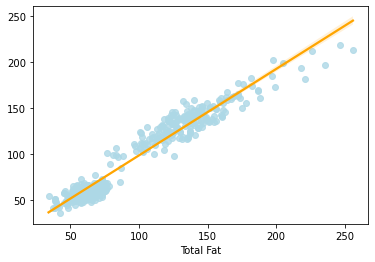

In [21]:
#plot the model predictions
preds = lr_model.predict(x_test)
fig, ax = plt.subplots()
ax = sn.regplot(x = y_test, y = preds, scatter_kws={'color': 'lightblue'}, line_kws={'color': 'orange'})
plt.show();

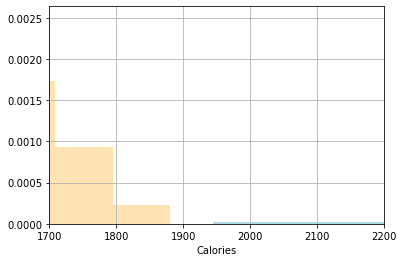

In [22]:
#1700-2200
#relatively few choices make the cut based on recommended calories
plt.xlabel('Calories')
plt.xlim(1700, 2200)
combined_df.query('healthy == "healthy"').Calories.hist(color = 'orange', alpha = .3, density = True);
combined_df.query('healthy == "random"').Calories.hist(color = 'lightblue', density = True);

In [23]:
#between %5-10 of daily meals have recommeded calories, many more healthy days
correct_calorie_df = combined_df.query('Calories >= 1700 and Calories <= 2200')
print(correct_calorie_df['healthy'].value_counts())
correct_calorie_df.head()

healthy    116
random       6
Name: healthy, dtype: int64


,Calories,Calories from Fat,Total Fat,Total Fat (% Daily Value),Saturated Fat,Saturated Fat (% Daily Value),Trans Fat,Cholesterol,Cholesterol (% Daily Value),Sodium,...,Dietary Fiber,Dietary Fiber (% Daily Value),Sugars,Protein,Vitamin A (% Daily Value),Vitamin C (% Daily Value),Calcium (% Daily Value),Iron (% Daily Value),healthy,all
181,2065.0,620.0,69.0,107.0,24.0,119.0,0.0,160.0,53.0,2490.0,...,12.0,54.0,147.0,65.0,61.0,352.0,62.0,66.0,random,
222,2065.0,690.0,77.5,120.0,28.0,137.0,1.0,190.0,64.0,2895.0,...,13.0,53.0,90.0,78.0,73.0,74.0,97.0,67.0,random,
790,2185.0,780.0,87.0,133.0,28.5,141.0,1.0,210.0,71.0,4100.0,...,13.0,55.0,80.0,86.0,20.0,217.0,57.0,77.0,random,
884,1945.0,610.0,68.0,105.0,24.0,121.0,0.5,225.0,76.0,3960.0,...,10.0,40.0,98.0,89.0,84.0,196.0,85.0,61.0,random,
926,2155.0,710.0,79.0,121.0,33.0,166.0,0.5,405.0,137.0,3390.0,...,10.0,36.0,169.0,78.0,75.0,374.0,95.0,56.0,random,


In [28]:
#Trans Fat, Sugars not included
the_bads =  ['Total Fat (% Daily Value)', 'Saturated Fat (% Daily Value)', 'Cholesterol (% Daily Value)',\
             'Sodium (% Daily Value)']
the_goods = ['Protein', 'Vitamin A (% Daily Value)', 'Carbohydrates (% Daily Value)','Dietary Fiber (% Daily Value)',\
             'Vitamin C (% Daily Value)','Calcium (% Daily Value)', 'Iron (% Daily Value)']

In [29]:
#WOW!!!!! 
combined_df.query('healthy == "random"')[the_bads].mean()

Total Fat (% Daily Value)        210.760
Saturated Fat (% Daily Value)    235.583
Cholesterol (% Daily Value)      144.857
Sodium (% Daily Value)           223.839
dtype: float64

In [30]:
#Potential
combined_df.query('healthy == "healthy"')[the_bads].mean()

Total Fat (% Daily Value)        91.344
Saturated Fat (% Daily Value)    93.526
Cholesterol (% Daily Value)      49.049
Sodium (% Daily Value)           97.954
dtype: float64

In [31]:
#kind of speaks for itself
combined_df.query('healthy == "random"')[the_goods].mean()

Protein                          124.923
Vitamin A (% Daily Value)         73.286
Carbohydrates (% Daily Value)    129.849
Dietary Fiber (% Daily Value)     69.545
Vitamin C (% Daily Value)        199.893
Calcium (% Daily Value)          124.189
Iron (% Daily Value)              89.830
dtype: float64

In [32]:
#protein is about right, the rest are very low, except vitamin C
combined_df.query('healthy == "healthy"')[the_goods].mean()

Protein                           55.690
Vitamin A (% Daily Value)         52.481
Carbohydrates (% Daily Value)     63.019
Dietary Fiber (% Daily Value)     50.920
Vitamin C (% Daily Value)        259.090
Calcium (% Daily Value)           56.426
Iron (% Daily Value)              53.071
dtype: float64

In [46]:
healthy_day_df = correct_calorie_df.copy()

healthy    116
random       6
Name: healthy, dtype: int64

In [47]:
#
healthy_day_df.mean(numeric_only = True)

Calories                         1771.475410
Calories from Fat                 635.942623
Total Fat                          69.668033
Total Fat (% Daily Value)         107.557377
Saturated Fat                      23.766393
Saturated Fat (% Daily Value)     118.885246
Trans Fat                           0.959016
Cholesterol                       190.737705
Cholesterol (% Daily Value)        63.475410
Sodium                           2754.221311
Sodium (% Daily Value)            114.385246
Carbohydrates                     224.434426
Carbohydrates (% Daily Value)      74.081967
Dietary Fiber                      13.442623
Dietary Fiber (% Daily Value)      56.245902
Sugars                             77.401639
Protein                            64.762295
Vitamin A (% Daily Value)          52.393443
Vitamin C (% Daily Value)         240.688525
Calcium (% Daily Value)            70.155738
Iron (% Daily Value)               61.672131
dtype: float64

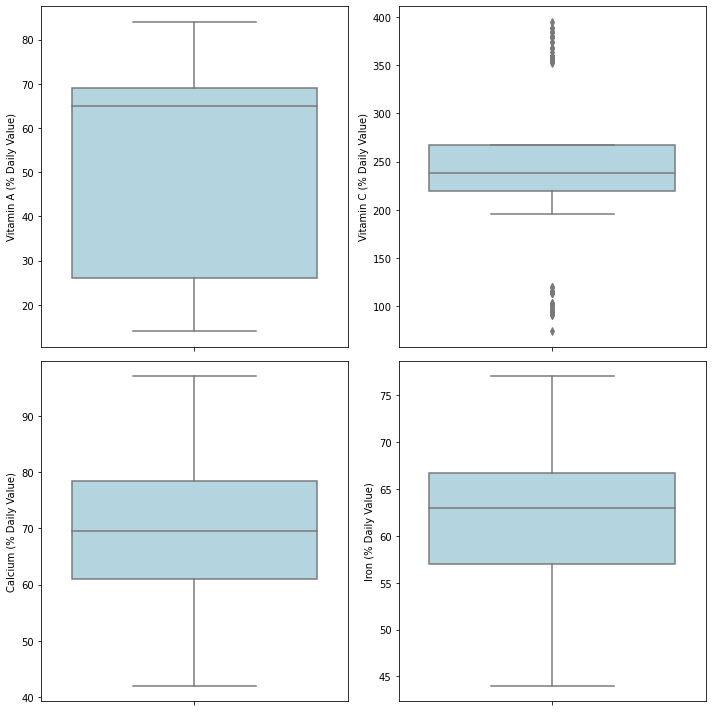

In [48]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
i = 0
for row in axes:
    for ax in row:
        sn.boxplot(x = 'all', y = vitmin_cols[i], data = healthy_day_df, ax = ax, color = 'lightblue').set_xlabel('')
        
        i += 1
plt.tight_layout()
plt.show()

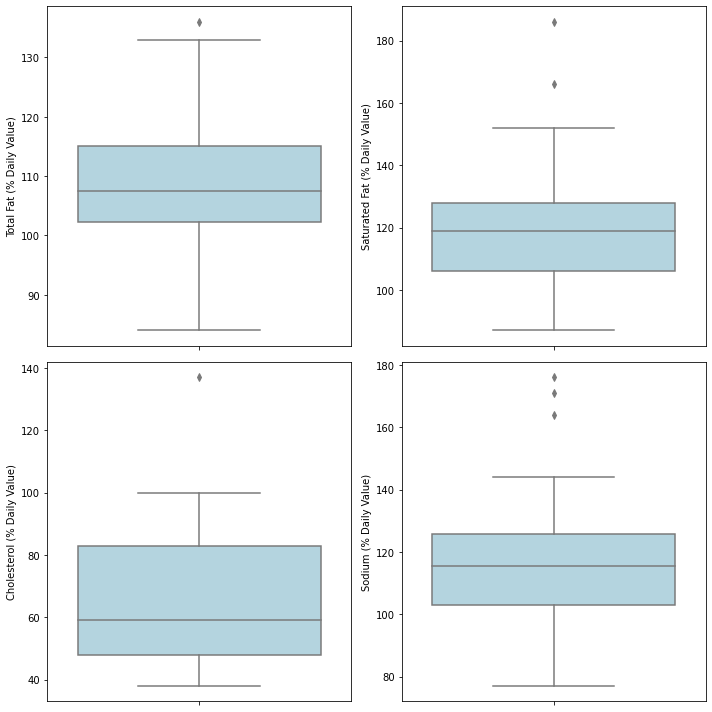

In [36]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
i = 0
for row in axes:
    for ax in row:
        sn.boxplot(x = 'all', y = the_bads[i], data = healthy_day_df, ax = ax, color = 'lightblue').set_xlabel('')
        
        i += 1
plt.tight_layout()
plt.show()

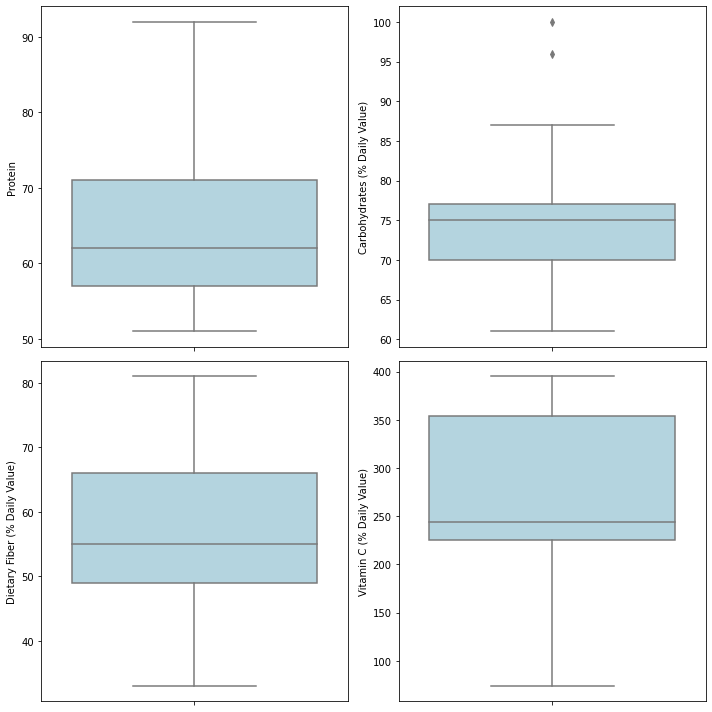

In [37]:
#Adult men need about 56 grams a day. Adult women need about 46 grams a day
#https://www.webmd.com/food-recipes/protein
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
t_goods = ['Protein', 'Carbohydrates (% Daily Value)','Dietary Fiber (% Daily Value)', 'Vitamin C (% Daily Value)']
i = 0
for row in axes:
    for ax in row:
        sn.boxplot(x = 'all', y = t_goods[i], data = healthy_day_df, ax = ax, color = 'lightblue').set_xlabel('')
        
        i += 1
plt.tight_layout()
plt.show()

Conclusion: It would be very difficult to eat a healthy diet from McDonalds exclusively. There may be some room for improvement given stricter choice regiment, but it should be noted there are sufficient deficiencies when healthy (low calorie) items are chosen. One big curiosity for me is the amount vitamin C, I wonder if it has food preservative qualities?